In [1]:
import os
from functools import partial

os.environ["JAX_ENABLE_X64"] = "True"

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_gaussian, draw_spergel
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_galaxy_params_skew,
)
from bpd.utils import DEFAULT_HYPERPARAMS, MAX_N_GALS_PER_GPU, process_in_batches


In [2]:
def _init_fnc(key: PRNGKeyArray, *, data: Array, true_params: dict):
    image = data
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()

    k1, k2, k3 = random.split(key, 3)

    tlhlr = true_params["lhlr"]
    lhlr = random.uniform(k1, shape=(), minval=tlhlr - 0.015, maxval=tlhlr + 0.015)

    te1 = true_params["e1"]
    e1 = random.uniform(k2, shape=(), minval=te1 - 0.1, maxval=te1 + 0.1)

    te2 = true_params["e2"]
    e2 = random.uniform(k3, shape=(), minval=te2 - 0.1, maxval=te2 + 0.1)
    return {
        "lf": jnp.log10(flux),
        "lhlr": lhlr,
        "e1": e1,
        "e2": e2,
        "dx": 0.0,
        "dy": 0.0,
    }

In [3]:
seed: int = 11
n_gals: int = 100
n_samples_per_gal: int = 100
sigma_e_int: float = 0.3
g1: float = 0.02
g2: float = 0.0
slen: int = 63
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 0.01


In [4]:
rng_key = random.key(seed)
pkey, nkey, gkey = random.split(rng_key, 3)



# galaxy parameters from prior
galaxy_params = sample_galaxy_params_skew(
    pkey, n=n_gals, g1=g1, g2=g2, **DEFAULT_HYPERPARAMS
)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

In [5]:
# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_images = get_target_images(
    nkey,
    draw_params,
    background=background,
    slen=slen,
    draw_type="exponential",
)
assert target_images.shape == (n_gals, slen, slen)

# interim samples are on 'sheared ellipticity'
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
true_params["dx"] = jnp.zeros_like(true_params["x"])
true_params["dy"] = jnp.zeros_like(true_params["y"])
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
}

In [6]:
# setup prior and likelihood
_logprior = partial(
    interim_gprops_logprior,
    sigma_e=sigma_e_int,
    free_flux_hlr=True,
    free_dxdy=True,
)
_draw_fnc = partial(draw_spergel, nu=0.5, slen=slen, fft_size=fft_size) # need to specify nu
_loglikelihood = partial(
    gaussian_image_loglikelihood,
    draw_fnc=_draw_fnc,
    background=background,
    free_flux_hlr=True,
    free_dxdy=True,
)

# prepare pipelines
gkeys = random.split(gkey, n_gals)
pipe = partial(
    pipeline_interim_samples_one_galaxy,
    initialization_fnc=_init_fnc,
    logprior=_logprior,
    loglikelihood=_loglikelihood,
    n_samples=n_samples_per_gal,
    initial_step_size=initial_step_size,
)
vpipe = vmap(jit(pipe))

In [7]:
# compilation on single target image
_ = vpipe(
    gkeys[0, None],
    target_images[0, None],
    {k: v[0, None] for k, v in fixed_params.items()},
    {k: v[0, None] for k, v in true_params.items()},
)

In [8]:
samples = process_in_batches(
    vpipe,
    gkeys,
    target_images,
    fixed_params,
    true_params,
    n_points=n_gals,
    batch_size=100,
)

Processing batches: 100%|██████████| 1/1 [00:53<00:00, 53.08s/it]


In [9]:
samples['e1'].shape

(100, 100)

# Check runs on SLURM (test)

In [20]:
from bpd.io import load_dataset
import matplotlib.pyplot as plt

In [12]:
fpath = "/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/interim_samples_99100_plus.npz"

In [14]:
ds = load_dataset(fpath)

In [16]:
ds.keys()

dict_keys(['samples', 'truth', 'hyper'])

In [17]:
ds['hyper']

{'g1': array(0.02),
 'g2': array(0.),
 'sigma_e_int': array(0.3),
 'nu': array(0.1),
 'shape_noise': array(0.2),
 'a_logflux': array(14.),
 'mean_logflux': array(2.45),
 'sigma_logflux': array(0.4),
 'mean_loghlr': array(-0.4),
 'sigma_loghlr': array(0.05)}

In [18]:
ds['samples']['e1'].shape

(1000, 300)

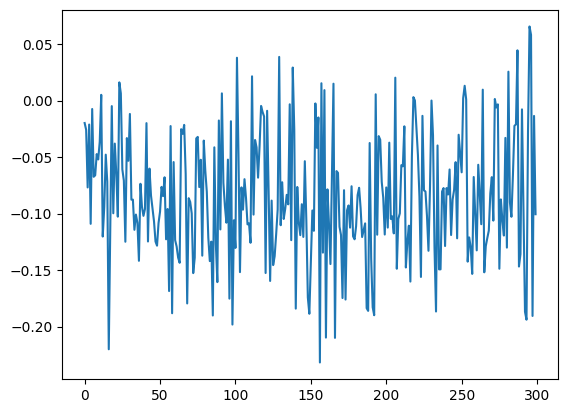

In [37]:
plt.plot(ds['samples']['dy'][11, :])